In [1]:
import os
import sys
import time
import glob
import json
import io
import pytesseract
from pytesseract import Output
from PIL import Image, ImageDraw
import cv2
from pathlib import Path
import pandas as pd
pd.set_option('display.max_rows', None)
pd.options.mode.chained_assignment = None
import layoutparser

In [2]:
nb_dir = '/home/srihari/anuvaad-toolkit/bm/anuvaad/anuvaad-etl/anuvaad-extractor/block-merger/src'
sys.path.append(nb_dir)
sys.path.append(os.path.split(nb_dir)[0])

import config
import src.utilities.app_context as app_context
from src.utilities.primalaynet.infer import draw_box
app_context.init()
app_context.application_context = dict({'task_id': 'BM-DUMMY'})

#path to craft model, weight can be pulled form the production bracnh of repo
config.CRAFT_MODEL_PATH = "/home/srihari/anuvaad-toolkit/bm/anuvaad/anuvaad-etl/anuvaad-extractor/block-merger/src/utilities/craft_pytorch/model/craft_mlt_25k.pth"
config.CRAFT_REFINE_MODEL_PATH  = '/home/srihari/anuvaad-toolkit/bm/anuvaad/anuvaad-etl/anuvaad-extractor/block-merger/src/utilities/craft_pytorch/model/craft_refiner_CTW1500.pth' 


from src.services.main import generate_response,break_blocks,merge_vertically,merge_horizontally,extract_images_and_text_regions

[2021-06-18 04:29:52,536] {geos.py:73} MainThread DEBUG in geos: Found GEOS DLL: <CDLL '/home/srihari/anaconda3/envs/nmt/lib/python3.7/site-packages/shapely/.libs/libgeos_c-a68605fd.so.1.13.1', handle 5580023be700 at 0x7fc4276a0850>, using it.
[2021-06-18 04:29:52,555] {geos.py:38} MainThread DEBUG in geos: Trying `CDLL(libc.so.6)`
[2021-06-18 04:29:52,556] {geos.py:55} MainThread DEBUG in geos: Library path: 'libc.so.6'
[2021-06-18 04:29:52,557] {geos.py:56} MainThread DEBUG in geos: DLL: <CDLL 'libc.so.6', handle 7fc4d28d5500 at 0x7fc4276a0650>
Loading weights of refiner from checkpoint (./model/craft_refiner_CTW1500.pth)


In [3]:
import layoutparser as lp
model_primalaynet = lp.Detectron2LayoutModel('lp://PrimaLayout/mask_rcnn_R_50_FPN_3x/config',label_map = {1:"TextRegion", 2:"ImageRegion", 3:"TableRegion", 4:"MathsRegion", 5:"SeparatorRegion", 6:"OtherRegion"},extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.5])


In [4]:
def draw_box(filepath,desired_width, desired_height,save_dir, df, color="green", save=False):
    image  = Image.open(filepath)
    image  = image.resize((desired_width, desired_height))
    draw   = ImageDraw.Draw(image)
    if type(df) is list:
        for i in df:
            for index, row in i.iterrows():
                left   = int(row['text_left'])
                right  = int(row['text_width'] + left)
                top    = int(row['text_top'])
                bottom = int(row["text_height"] + top)
                draw.rectangle(((left, top), (right,bottom)), outline=color,width=3)
    else:

        for index, row in df.iterrows():
            left   = int(row['text_left'])
            right  = int(row['text_width'] + left)
            top    = int(row['text_top'])
            bottom = int(row["text_height"] + top)
            draw.rectangle(((left, top), (right,bottom)), outline=color,width=3)
    save_filepath = os.path.join(save_dir, os.path.basename(filepath))
    if save:
        image.save(save_filepath)
    
    return image

In [32]:
#dir which contains the pdf file
input_dir = '/home/srihari/anuvaad-toolkit/bm/anuvaad/anuvaad-etl/anuvaad-extractor/block-merger/upload/'
#filename = 'footer_test.pdf'
#filename  = 'grade7-review2timetable.pdf'
#filename = '20695.pdf'
#filename = 's2_en.pdf'
#filename = 'scan_1.pdf'
#filename = 'ncert.pdf'
#filename = 'p_df_error.pdf'
#filename  = 'test_table.pdf'
#filename  = 'NDEAR.pdf'
filename   = '10392_2009_3_1501_13358_Judgement_29-Mar-2019_TAM.pdf'
#filename = '40404.pdf'
#filename = '4543_2011_3_108_14581_Judgement_27-May-2019_HIN.pdf'
#filename   = 'text_coordinates_issue_on_page_9_2pgss.pdf'

lang     = 'ta'

In [33]:
[pdf_data,flags] = extract_images_and_text_regions(filename, input_dir,lang,page_layout='single_column')
[pdf_data,flags] = merge_horizontally([pdf_data,flags])
[pdf_data,flags] = merge_vertically([pdf_data,flags])
[pdf_data,flags] = break_blocks([pdf_data,flags])
response         = generate_response([pdf_data,flags])

[2021-06-18 09:51:49,357] {loghandler.py:21} MainThread INFO in loghandler: document preprocessing started ===>
[2021-06-18 09:51:49,361] {loghandler.py:21} MainThread INFO in loghandler: created processing directories successfully /home/srihari/anuvaad-toolkit/bm/anuvaad/anuvaad-etl/anuvaad-extractor/block-merger/upload/10392_2009_3_1501_13358_Judgement_29-Mar-2019_TAM_b36046d8-cfec-11eb-a371-dfac0c6c63f8
[2021-06-18 09:51:49,364] {loghandler.py:21} MainThread INFO in loghandler: filepath /home/srihari/anuvaad-toolkit/bm/anuvaad/anuvaad-etl/anuvaad-extractor/block-merger/upload/10392_2009_3_1501_13358_Judgement_29-Mar-2019_TAM.pdf, working_dir /home/srihari/anuvaad-toolkit/bm/anuvaad/anuvaad-etl/anuvaad-extractor/block-merger/upload/10392_2009_3_1501_13358_Judgement_29-Mar-2019_TAM_b36046d8-cfec-11eb-a371-dfac0c6c63f8
[2021-06-18 09:51:49,613] {loghandler.py:21} MainThread INFO in loghandler: Extracting xml of /home/srihari/anuvaad-toolkit/bm/anuvaad/anuvaad-etl/anuvaad-extractor/bloc

In [34]:
response

{'result': [{'page_no': 1,
   'page_width': 892,
   'page_height': 1263,
   'lines': None,
   'tables': [],
   'images': [{'text_top': 0,
     'text_left': 0,
     'text_width': 893,
     'text_height': 1263,
     'base64': 'iVBORw0KGgoAAAANSUhEUgAAA30AAATvCAIAAAA94Q4oAAAb9klEQVR4AezBoa4YhJZA0XOS62owRVXUI5Ak8DQCg6voR/AFJCQ4PL/A9RgQ6DbhL+qrryPZk0wyajITmMzp4+WttbYaAAA4ttUAAMCxrQYAAI5tNQAAcGyrAQCAY1sNAAAc22oAAODYVgMAAMe2GgAAOLbVAADAsa0GAACObTUAAHBsqwEAgGNbDQAAHNtqAADg2FYDAADHthoAADi21QAAwLGtBgAAjm01AABwbKsBAIBjWw0AABzbagAA4NhWAwAAx7YaAAA4ttUAAMCxrQYAAI5tNQAAcGyrAQCAY1sNAAAc22oAAODYVgMAAMe2GgAAOLbVAADAsa0GAACObTUAAHBsqwEAgGNbDQAAHNtqAADg2FYDAADHthoAADi21QAAwLGtBgAAjm01AABwbKsBAIBjWw0AABzbagAA4NhWAwAAx7YaAAA4ttUAAMCxrQYAAI5tNQAAcGyrAQCAY1sNAAAc22oAAODYVgMAAMe2GgAAOLbVAADAsa0GAACObTUAAHBsqwEAgGNbDQAAHNtqAADg2FYDAADHthoAADi21QAAwLGtBgAAjm01AABwbKsBAIBjWw0AABzbagAA4NhWAwAAx7YaAAA4ttUAAMCxrQYAAI5tNQAAcGyrAQCAY1sNAAAc22oAAODYVgMAAMe2GgAAOLbVAADAsa0GAACObTUAAHBsqwEAgGNbDQAAHNtqAADg2FYDAADHthoAADi

In [35]:
flags

{'doc_class': 'class_2', 'page_layout': 'double_column'}

In [ ]:
# width_ratio = pdf_data['page_width'] / pdf_data['pdf_image_width']
# height_ratio = pdf_data['page_height'] / pdf_data['pdf_image_height']
# predict_primanet(img_filepath,pdf_bg_img_filepaths,to_check[0],width_ratio,height_ratio)

desired_width 892
desired_height 1263


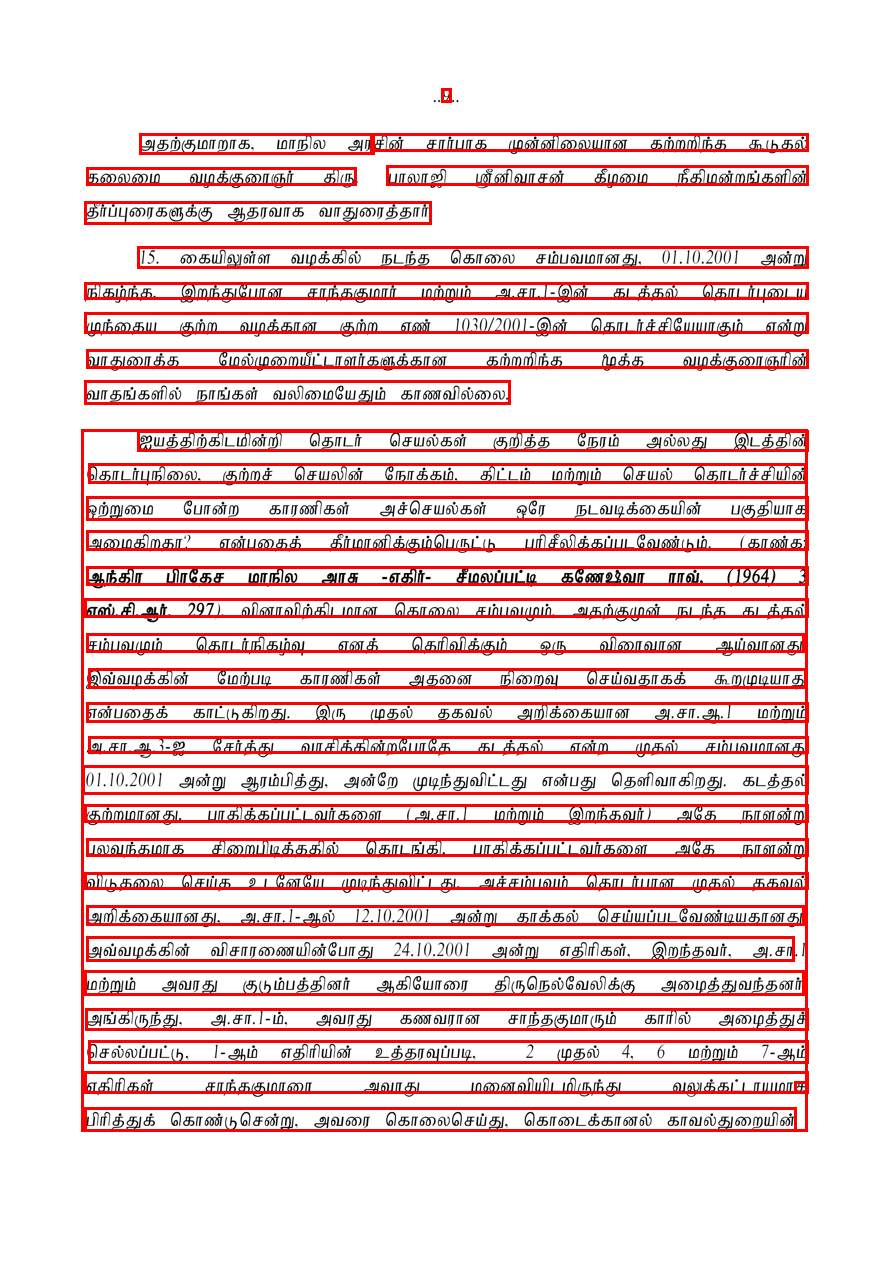

In [37]:
page_index = 0
to_check        = pdf_data['h_dfs']
#to_check_in_df        = pdf_data['v_dfs'][page_index]
img_filepath    = pdf_data['pdf_image_paths'][page_index]
pdf_bg_img_filepaths  = pdf_data['pdf_bg_img_filepaths'][page_index]
df              = to_check[page_index]

#desired_width, desired_height = pdf_data['pdf_image_width'], pdf_data['pdf_image_height']
#desired_width, desired_height = pdf_data['page_width'] *1.29, pdf_data['page_height'] *0.77
desired_width, desired_height = pdf_data['page_width'][page_index] , pdf_data['page_height'][page_index]
print("desired_width",desired_width)
print("desired_height",desired_height)

draw_box(img_filepath,int(desired_width), int(desired_height), 'path',df, color="red", save=False) 

In [ ]:
df

In [ ]:
pdf_data['pdf_image_height']

In [ ]:
for i in to_check_in_df['children']:
    d =pd.read_json(i)
    print(d)
    print(d['children'])

In [ ]:
image.size

In [ ]:
import numpy as np
p_df_image = draw_box(img_filepath,desired_width, desired_height, 'path',df, color="red", save=False)
sc_pdf_image = draw_box(img_filepath,desired_width, desired_height, 'path',to_check_in_df, color="red", save=False)
stiched_imag = np.hstack([np.array(p_df_image) ,np.array(sc_pdf_image)])
compare_image = Image.fromarray(stiched_imag)
compare_image.save("/home/naresh/1.jpg")

In [ ]:
def predict_primanet(image_path,bg_image_path,in_df,width_ratio,height_ratio):
    image1  = cv2.imread(image_path)
    image2  = cv2.imread(bg_image_path)
    image = image1[..., ::-1] 
    layout = model_primalaynet.detect(image)
    boxes,coords = draw_box(layout, in_df,width_ratio,height_ratio)
    final_coord= []
    for coord in coords:
        temp_dict={}
        temp_dict['text_left']=coord[0]; temp_dict['text_top']=coord[1]
        temp_dict['text_width']=coord[2]; temp_dict['text_height']=coord[3]
        #draw.rectangle(coord, width=3,outline='red')
        final_coord.append(temp_dict)
        cv2.rectangle(image1, (int(coord[0]),int(coord[1])), (int(coord[2]),int(coord[3])),(255,255,0),3)
        cv2.rectangle(image2, (int(coord[0]*width_ratio),int(coord[1]*height_ratio)), (int(coord[2]*width_ratio),int(coord[3]*height_ratio)),(255,255,0),3)

        cv2.imwrite("1.jpg",image1)
        cv2.imwrite("2.jpg",image2)

    return final_coord

In [ ]:
pdf_data.keys()

In [ ]:
json.dumps(response)

In [ ]:
len(pdf_data['img_dfs'])

In [ ]:
page_1 = pdf_data['img_dfs'][0]

In [ ]:
page_1